#**VOLATILITY TRADING**
---

##0.REFERENCE

https://claude.ai/share/b8701fdb-4745-44e7-a80b-1df3f9a36fdf

##1.CONTEXT



Every trader faces a fundamental problem: markets don't behave the same way all the time. Some days are calm, with prices barely moving. Other days are chaotic, with wild swings that can make or break a portfolio. This changing nature of market volatility creates both opportunity and danger.

Think of volatility like the weather. Just as you wouldn't wear the same clothes in winter and summer, you shouldn't trade the same way in calm markets and turbulent ones. When markets are quiet, you might increase your position sizes to capture returns. When volatility spikes, you need to dial back exposure to avoid getting hurt. This intuitive idea forms the foundation of risk targeting, one of the most powerful concepts in modern portfolio management.

The challenge is that volatility isn't directly observable. You can see prices, but volatility is something you must estimate from price movements. It's like trying to measure the temperature of a room by watching how quickly ice melts. Different methods give different answers, and choosing the right approach matters tremendously for your bottom line.

This chapter introduces three essential volatility estimation techniques that every quantitative practitioner should understand. Rolling window volatility is the simplest approach, looking backward over a fixed time period to calculate how much prices have moved. It's straightforward and transparent, making it a natural starting point. Exponentially weighted moving average volatility refines this idea by giving more weight to recent observations, allowing your estimates to adapt faster when market conditions change. Finally, GARCH models recognize that volatility tends to cluster—turbulent periods follow turbulent periods, and calm follows calm—building this persistence directly into the estimation framework.

But estimating volatility is only half the battle. The real value comes from using these estimates to make better trading decisions through risk targeting. The core principle is elegant: adjust your position sizes inversely to volatility so that your portfolio maintains a consistent level of risk over time. When volatility is low, you trade larger. When volatility is high, you trade smaller. This approach helps smooth out your returns and prevents the catastrophic losses that often occur during volatility spikes.

What makes this chapter different from typical academic treatments is its emphasis on practical implementation and governance. We don't just show you the formulas—we show you how to build these systems correctly from the ground up. Every line of code is written with causality in mind, ensuring that you never accidentally use future information in your estimates. We include explicit tests to verify that your volatility forecasts truly depend only on past data, catching the subtle look-ahead biases that plague many production systems.

The synthetic market generator lets you see exactly how these techniques perform under controlled conditions with known volatility regimes. You can watch in real time how different estimators track true volatility, where they excel, and where they struggle. You'll observe how risk targeting transforms a raw trading signal into a more robust strategy with controlled drawdowns and steadier performance.

By the end of this notebook, you won't just understand volatility modeling and risk targeting conceptually—you'll have working, tested, production-quality code that implements these ideas correctly. Whether you're building your first quantitative strategy or refining an existing system, these tools will help you trade more intelligently in an uncertain world.


##2.LIBRARIES AND ENVIRONMENT

###2.1.OVERVIEW



The synthetic market generator creates realistic price paths that mimic real financial markets, giving you complete control over market conditions for testing and learning. Unlike using actual historical data where you never know the true volatility, synthetic data lets you see exactly what's happening under the hood.

The generator builds prices using a log-return framework, which is standard in quantitative finance. Each day's return comes from combining three components: a drift term representing the average market direction, a volatility term capturing random fluctuations, and occasional jump events that simulate sudden market shocks like earnings surprises or geopolitical events.

What makes this generator particularly valuable is its regime-switching capability. Markets don't stay constant—they cycle through periods of calm and chaos. The generator divides time into distinct regimes, each with its own drift and volatility parameters. You might have a low-volatility regime with small daily moves, followed by a high-volatility crisis period with wild swings, then a recovery phase with moderate volatility. This structure mirrors reality, where market character genuinely changes over time.

The jump mechanism adds another layer of realism. Even in normal times, markets occasionally gap up or down on unexpected news. The generator randomly sprinkles these jumps throughout the price path at a configurable frequency, creating the fat-tailed return distributions we observe in real markets.

Every aspect is deterministic and reproducible. Set the random seed, and you'll get identical results every time—critical for debugging and validating your models. The generator outputs not just prices and returns, but also the true underlying volatility at each point in time. This ground truth is invaluable because you can compare your volatility estimates against reality and measure exactly how well different methods perform.

By controlling the data generation process, you eliminate the confounding factors that make real data analysis messy. You know there's no survivorship bias, no corporate actions to adjust for, no missing data or stale prices. This clean environment lets you focus purely on understanding how volatility estimation and risk targeting work before tackling the complications of live markets.

###2.2.CODE AND IMPLEMENTATION

In [2]:
import os
import json
import math
import time
import hashlib
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt


def now_utc_compact() -> str:
    """Return current UTC timestamp in compact format."""
    return datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


def sha256_bytes(b: bytes) -> str:
    """Compute SHA256 hash of bytes."""
    return hashlib.sha256(b).hexdigest()


def sha256_array(x: np.ndarray) -> str:
    """Hash numpy array including shape and dtype to avoid collisions."""
    h = hashlib.sha256()
    h.update(str(x.shape).encode("utf-8"))
    h.update(str(x.dtype).encode("utf-8"))
    h.update(np.ascontiguousarray(x).view(np.uint8))
    return h.hexdigest()


def ensure_dir(p: str) -> None:
    """Create directory if it doesn't exist."""
    os.makedirs(p, exist_ok=True)


def write_json(path: str, obj: dict) -> None:
    """Write dictionary to JSON file with sorted keys."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, sort_keys=True)


def write_text(path: str, s: str) -> None:
    """Write string to text file."""
    with open(path, "w", encoding="utf-8") as f:
        f.write(s)


def clip_scalar(x: float, lo: float, hi: float) -> float:
    """Clip scalar value to range [lo, hi]."""
    return lo if x < lo else hi if x > hi else x


def clip_array(x: np.ndarray, lo: float, hi: float) -> np.ndarray:
    """Clip array values to range [lo, hi]."""
    return np.minimum(np.maximum(x, lo), hi)


# -------------------------
# Configuration & Deterministic Seed
# -------------------------
CONFIG = {
    "chapter": 10,
    "title": "Volatility Modeling & Risk Targeting",
    "seed": 7,

    # Synthetic market generator
    "synthetic": {
        "T": 2000,                  # number of price points (includes t=0)
        "p0": 100.0,
        "regime_schedule": [        # piecewise constant regimes
            # Each tuple: (length, drift_per_step, vol_per_step)
            (500,  0.00020, 0.0070),
            (400,  0.00005, 0.0150),
            (400, -0.00010, 0.0100),
            (500,  0.00015, 0.0200),
        ],
        "jump_prob": 0.007,         # probability of jump per step
        "jump_scale": 0.050,        # jump magnitude scale (log-return additive)
        "microstructure_noise": 0.0, # set >0 to add noise to prices (conceptual)
    },

    # Returns definition
    "returns": {
        "type": "log",              # "log" or "simple"
    },

    # Volatility estimators
    "vol_estimators": {
        "rolling": {
            "L": 20,
            "ddof": 1,
        },
        "ewma": {
            "half_life": 20,        # interpretability
            # lambda will be derived deterministically from half-life
            "init_mode": "burnin",  # "burnin" or "prior"
            "burnin_L": 50,
            "prior_sigma": 0.01,
        },
        "garch11": {
            # We will estimate (alpha, beta) by deterministic grid search.
            # omega will be anchored to match sample variance: omega = (1-a-b)*s2
            "estimate": True,
            "grid_alpha": [0.02, 0.30, 0.02],  # start, end, step
            "grid_beta":  [0.50, 0.99, 0.02],
            "persist_max": 0.995,              # enforce alpha+beta < persist_max
            "init_mode": "uncond",             # "uncond" or "sample"
        },
    },

    # Raw signal (simple, causal)
    "signal": {
        "type": "ma_crossover",     # "ma_crossover" or "momentum_sign"
        "ma_short": 20,
        "ma_long":  80,
        "momentum_L": 20,
        "w_raw_levels": [-1.0, 0.0, 1.0],
    },

    # Risk targeting policy
    "risk_targeting": {
        "sigma_star_daily": 0.010,  # target daily vol in strategy-return units
        "sigma_floor": 0.002,       # volatility floor to prevent leverage blowups
        "epsilon": 1e-12,           # numerical guard
        "w_max": 3.0,               # hard leverage cap
        "mult_smoothing": {
            "enabled": False,       # keep OFF by default (turnover tradeoff)
            "rho": 0.90,
        },
        "availability_policy": "abstain",  # "abstain" or "hold_last"
    },

    # Backtest + reporting
    "reporting": {
        "annualization": 252,
        "plot_max_points": 2000,
    },

    # Artifacts
    "artifacts": {
        "root": "/content/ch10_artifacts",
        "save_arrays": True,
    }
}

np.random.seed(CONFIG["seed"])

RUN_ID = f"ch10_{now_utc_compact()}_{CONFIG['seed']}"
ART_ROOT = os.path.join(CONFIG["artifacts"]["root"], RUN_ID)
ensure_dir(ART_ROOT)

# Write run manifest early (governance: manifest starts before computations)
RUN_MANIFEST = {
    "run_id": RUN_ID,
    "created_utc": now_utc_compact(),
    "chapter": CONFIG["chapter"],
    "title": CONFIG["title"],
    "seed": CONFIG["seed"],
    "config_sha256": sha256_bytes(json.dumps(CONFIG, sort_keys=True).encode("utf-8")),
    "artifacts_root": ART_ROOT,
    "warnings": [],
    "tests": {},
    "data_fingerprint": {},
    "outputs": {},
}
write_json(os.path.join(ART_ROOT, "config.json"), CONFIG)
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)

print("RUN_ID:", RUN_ID)
print("ART_ROOT:", ART_ROOT)


# ==========================================================
# Cell 2 — Synthetic Market Generator (Regime Vol + Jumps)
# ==========================================================
def generate_synthetic_prices(cfg: dict) -> dict:
    """
    Generate a synthetic price path with piecewise-constant drift/vol regimes,
    plus occasional jumps in log-return space.

    Output dict includes:
      - t: integer time index
      - P: prices (len T)
      - r: returns aligned to P (len T), with r[0]=nan, r[t]=log(P[t]/P[t-1]) for t>=1
      - regimes: regime id per t (len T)
      - true_sigma: per-step volatility used in generation (len T)
    """
    T = int(cfg["T"])
    p0 = float(cfg["p0"])
    schedule = cfg["regime_schedule"]
    jump_prob = float(cfg["jump_prob"])
    jump_scale = float(cfg["jump_scale"])
    micro = float(cfg["microstructure_noise"])

    # Build regime arrays of length T-1 returns (from t-1 to t)
    mus = []
    sigmas = []
    regime_ids = []

    rid = 0
    total = 0
    for (L, mu, sig) in schedule:
        L = int(L)
        for _ in range(L):
            if total >= T - 1:
                break
            mus.append(float(mu))
            sigmas.append(float(sig))
            regime_ids.append(rid)
            total += 1
        rid += 1
        if total >= T - 1:
            break

    # If schedule shorter than needed, pad with last regime
    while total < T - 1:
        mus.append(mus[-1])
        sigmas.append(sigmas[-1])
        regime_ids.append(regime_ids[-1])
        total += 1

    mus = np.array(mus, dtype=np.float64)       # length T-1
    sigmas = np.array(sigmas, dtype=np.float64) # length T-1
    regime_ids = np.array(regime_ids, dtype=np.int64)

    # Innovations + occasional jumps in log-return
    eps = np.random.randn(T - 1)
    jumps = (np.random.rand(T - 1) < jump_prob).astype(np.float64)
    jump_sign = np.sign(np.random.randn(T - 1))
    jump_term = jumps * jump_sign * (jump_scale * np.abs(np.random.randn(T - 1)))

    log_r = mus + sigmas * eps + jump_term

    # Price path
    P = np.empty(T, dtype=np.float64)
    P[0] = p0
    for t in range(1, T):
        P[t] = P[t - 1] * math.exp(log_r[t - 1])

    # Optional microstructure noise (conceptual)
    if micro > 0.0:
        P = P * np.exp(micro * np.random.randn(T))

    # Return series aligned to price points
    r = np.empty(T, dtype=np.float64)
    r[0] = np.nan
    r[1:] = log_r  # log_r[t-1] = log(P[t]/P[t-1])

    regimes = np.empty(T, dtype=np.int64)
    regimes[0] = regime_ids[0]
    regimes[1:] = regime_ids

    true_sigma = np.empty(T, dtype=np.float64)
    true_sigma[0] = sigmas[0]
    true_sigma[1:] = sigmas

    return {"t": np.arange(T), "P": P, "r": r, "regimes": regimes, "true_sigma": true_sigma}


SYN = generate_synthetic_prices(CONFIG["synthetic"])
t = SYN["t"]
P = SYN["P"]
r = SYN["r"]  # log returns aligned with P (r[0]=nan, r[t]=log(P[t]/P[t-1]))
regimes = SYN["regimes"]
true_sigma = SYN["true_sigma"]

assert len(P) == CONFIG["synthetic"]["T"], "Price series length mismatch"
assert np.isfinite(P).all(), "Price series contains non-finite values"
assert np.all(P > 0.0), "Price series contains non-positive values"

print("Synthetic series built.")
print(f"P[0]={P[0]:.2f}, P[-1]={P[-1]:.2f}")
print("Return sample (first 5 non-nan):", r[1:6])


RUN_ID: ch10_20251222T112928Z_7
ART_ROOT: /content/ch10_artifacts/ch10_20251222T112928Z_7
Synthetic series built.
P[0]=100.00, P[-1]=37.43
Return sample (first 5 non-nan): [ 0.01203368 -0.00306156  0.00042974  0.00305261 -0.00532246]


/tmp/ipython-input-3063630242.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


## 3.DATA FINGER PRINTING AND QUALITY CHECKS

###3.1.OVERVIEW



Before running any analysis, professional quantitative systems must verify data quality and create an audit trail. This section implements data governance practices that separate amateur code from production-grade systems.

The data fingerprint is like a unique ID card for your dataset. It captures cryptographic hashes of the price and return arrays, ensuring you can always verify you're working with the exact same data across different runs. This matters tremendously in production—if results change unexpectedly, you can immediately check whether the input data changed or if something else broke in your pipeline.

The missingness summary counts how many data points are valid versus missing or infinite. Real market data often has gaps from holidays, trading halts, or data vendor errors. By quantifying missingness upfront, you establish baseline expectations and can flag anomalies. Even with synthetic data, these checks catch bugs in the generator itself.

The zero-run detection identifies sequences of consecutive zero returns, which signal stale prices in real data. When a stock stops trading or a data feed freezes, you see unchanging prices that generate zero returns. Long zero-run sequences are red flags requiring investigation. For synthetic data, this test should show minimal zero runs, confirming the generator produces realistic variation.

The return alignment verification is critical for preventing subtle bugs. It explicitly checks that the return series matches the mathematical definition—each return must equal the log price change. A mismatch here would indicate a fundamental error in data construction that could invalidate all downstream analysis.

All findings get written to the manifest file, creating permanent documentation of data provenance. This governance practice ensures reproducibility and makes debugging vastly easier when something goes wrong months later.

###3.2.CODE AND IMPLEMENTATION

In [3]:

def summarize_missingness(x: np.ndarray) -> dict:
    """Compute missingness statistics for array."""
    is_nan = np.isnan(x)
    return {
        "n": int(x.size),
        "n_nan": int(is_nan.sum()),
        "n_finite": int(np.isfinite(x).sum()),
    }


def zero_run_lengths(x: np.ndarray, tol: float = 0.0) -> dict:
    """
    Detect sequences of returns that are exactly (or near) zero.
    This is a proxy for stale prices in real data. For synthetic data,
    it should usually be rare.
    """
    z = np.zeros_like(x, dtype=np.int64)
    # treat nan as non-zero for run purposes
    mask = np.isfinite(x) & (np.abs(x) <= tol)
    z[mask] = 1
    # compute run lengths
    max_run = 0
    cur = 0
    for i in range(z.size):
        if z[i] == 1:
            cur += 1
            if cur > max_run:
                max_run = cur
        else:
            cur = 0
    return {"max_zero_run": int(max_run), "tol": float(tol)}


# Return definition check (log)
if CONFIG["returns"]["type"] == "log":
    # Verify r[t] == log(P[t]/P[t-1]) for t>=1
    check = np.log(P[1:] / P[:-1])
    err = np.max(np.abs(check - r[1:]))
    assert err < 1e-12, f"Return alignment error: {err}"
else:
    # If you switch to simple returns, recompute r accordingly
    r[1:] = (P[1:] / P[:-1]) - 1.0

# Data fingerprint
data_fp = {
    "instrument": "SYNTHETIC_1",
    "frequency": "DAILY_INDEXED",
    "span": {"t0": int(t[0]), "tN": int(t[-1])},
    "prices_sha256": sha256_array(P),
    "returns_sha256": sha256_array(np.nan_to_num(r, nan=0.0)),
    "missingness_prices": summarize_missingness(P),
    "missingness_returns": summarize_missingness(r),
    "zero_runs_returns": zero_run_lengths(r[1:], tol=0.0),
}
RUN_MANIFEST["data_fingerprint"] = data_fp
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)

print("Data fingerprint recorded.")
print(f"prices_sha256: {data_fp['prices_sha256'][:16]}...")
print(f"returns_sha256: {data_fp['returns_sha256'][:16]}...")


Data fingerprint recorded.
prices_sha256: 18a794a509b99bcc...
returns_sha256: 1bc6e3f59c40e655...


##4.VOLATILITY ESTIMATORS

###4.1.OVERVIEW


This section implements three fundamental approaches to estimating market volatility, each with different strengths and tradeoffs that practitioners must understand.

Rolling window volatility is the simplest method. It calculates standard deviation over the most recent fixed number of periods—say the last twenty days. This approach is transparent and easy to explain to stakeholders, making it popular in practice. However, it treats all observations in the window equally and can be slow to respond when market conditions change abruptly. The window length creates a tradeoff: shorter windows adapt faster but are noisier, while longer windows are smoother but lag behind regime changes.

Exponentially weighted moving average volatility refines this idea by giving more weight to recent observations. Instead of treating the last twenty days equally, yesterday's return matters more than last week's return, which matters more than last month's. The half-life parameter controls how quickly weights decay—a twenty-day half-life means observations from twenty days ago get half the weight of today's observation. This exponential weighting helps the estimator adapt faster to changing market conditions while maintaining smoothness.

GARCH models recognize that volatility exhibits persistence and clustering. When markets are turbulent today, they tend to stay turbulent tomorrow. When they're calm, calmness persists. The GARCH framework models this explicitly through parameters that control how much today's volatility depends on yesterday's volatility and yesterday's squared returns. The grid search finds optimal parameters by testing combinations and selecting those that best explain the observed return patterns.

Each estimator produces a one-step-ahead volatility forecast available at time t for scaling positions over the next period. The critical implementation detail is strict causality—estimates at time t use only information available through time t, never peeking into the future. This prevents the look-ahead bias that invalidates most backtest results.

###4.2.CODE AND IMPLEMENTATION

In [4]:

# ==========================================================
# Cell 4 — Volatility Estimators (Rolling, EWMA, GARCH(1,1))
# ==========================================================
def rolling_vol_causal(r: np.ndarray, L: int, ddof: int = 1) -> np.ndarray:
    """
    Causal rolling volatility estimate available at time t:
      sigma_hat[t] uses returns r[t-L+1 .. t] (inclusive),
      where r[t] is known at time t (end-of-day close in this convention).
    For t < L, sigma_hat[t]=nan.

    r is aligned with prices: r[0]=nan, r[t]=return from t-1 to t.
    """
    T = r.size
    out = np.full(T, np.nan, dtype=np.float64)
    if L <= 1:
        raise ValueError("L must be >= 2 for variance estimation with ddof=1")

    for t in range(1, T):
        start = t - L + 1
        if start < 1:
            continue
        window = r[start:t+1]
        # Must be finite
        if not np.isfinite(window).all():
            continue
        mu = float(np.mean(window))
        # sample variance with ddof
        denom = L - ddof
        if denom <= 0:
            continue
        v = float(np.sum((window - mu) ** 2) / denom)
        out[t] = math.sqrt(max(v, 0.0))
    return out


def ewma_lambda_from_half_life(half_life: float) -> float:
    """Calculate EWMA lambda from half-life: lambda = 2^(-1/half_life)."""
    if half_life <= 0:
        raise ValueError("half_life must be > 0")
    return float(2.0 ** (-1.0 / half_life))


def ewma_vol_causal(r: np.ndarray, half_life: float, init_mode: str,
                    burnin_L: int, prior_sigma: float) -> np.ndarray:
    """
    EWMA volatility estimate available at time t:
      sigma2[t] = lambda*sigma2[t-1] + (1-lambda)*r[t]^2  (uses r[t] known at t)
    with deterministic initialization.

    Returns sigma_hat[t] = sqrt(sigma2[t]).
    """
    T = r.size
    lam = ewma_lambda_from_half_life(half_life)
    sigma2 = np.full(T, np.nan, dtype=np.float64)

    # Initialize sigma2[0] (unused) and sigma2[1] in a causal way
    if init_mode == "prior":
        sigma2_init = float(prior_sigma) ** 2
        sigma2[0] = sigma2_init
        # first usable update at t=1 (if r[1] finite)
        if np.isfinite(r[1]):
            sigma2[1] = lam * sigma2_init + (1.0 - lam) * float(r[1] ** 2)
        else:
            sigma2[1] = sigma2_init
    elif init_mode == "burnin":
        # Use the first burnin_L returns (ending at t=burnin_L) to seed sigma2
        L0 = int(burnin_L)
        if L0 < 2:
            raise ValueError("burnin_L must be >= 2")
        # We require r[1:L0+1] finite to initialize
        if not np.isfinite(r[1:L0+1]).all():
            # fallback to prior if burn-in not feasible
            sigma2_init = float(prior_sigma) ** 2
        else:
            x = r[1:L0+1]
            mu = float(np.mean(x))
            v = float(np.sum((x - mu) ** 2) / (L0 - 1))
            sigma2_init = max(v, 1e-18)
        sigma2[0] = sigma2_init
        # run recursion forward
        for t in range(1, T):
            if not np.isfinite(r[t]):
                sigma2[t] = sigma2[t-1]
            else:
                sigma2[t] = lam * sigma2[t-1] + (1.0 - lam) * float(r[t] ** 2)
    else:
        raise ValueError("init_mode must be 'burnin' or 'prior'")

    # If prior mode, continue recursion
    if init_mode == "prior":
        for t in range(2, T):
            if not np.isfinite(r[t]):
                sigma2[t] = sigma2[t-1]
            else:
                sigma2[t] = lam * sigma2[t-1] + (1.0 - lam) * float(r[t] ** 2)

    sigma = np.sqrt(np.maximum(sigma2, 0.0))
    sigma[0] = np.nan  # r[0] is nan; sigma[0] not used
    return sigma


def garch11_loglik_gaussian(r: np.ndarray, omega: float, alpha: float, beta: float,
                            init_mode: str = "uncond") -> float:
    """
    Gaussian (quasi-)log-likelihood for GARCH(1,1) with zero mean.

    Model (standard, for likelihood):
      r[t] = sigma[t] * eps[t],  E[eps]=0, Var[eps]=1
      sigma2[t] = omega + alpha*r[t-1]^2 + beta*sigma2[t-1]   for t>=2
      sigma2[1] initialized

    Here r is aligned with prices: r[0]=nan, r[t] valid for t>=1.
    Likelihood uses returns r[1..T-1]. We ignore r[0].

    Returns total log-likelihood (higher is better).
    """
    if omega <= 0.0 or alpha < 0.0 or beta < 0.0:
        return -np.inf
    if alpha + beta >= 1.0:
        return -np.inf

    T = r.size
    # Use only finite returns
    if not np.isfinite(r[1:]).all():
        return -np.inf

    # sample variance (for initialization)
    x = r[1:]
    mu = float(np.mean(x))
    s2 = float(np.sum((x - mu) ** 2) / (x.size - 1))

    sigma2 = np.empty(T, dtype=np.float64)
    sigma2[0] = np.nan

    if init_mode == "uncond":
        # unconditional variance implied by parameters
        sigma2_1 = omega / (1.0 - alpha - beta)
    elif init_mode == "sample":
        sigma2_1 = s2
    else:
        return -np.inf

    sigma2[1] = max(sigma2_1, 1e-18)

    ll = 0.0
    # likelihood for t=1 uses sigma2[1]
    for t in range(1, T):
        rt = float(r[t])
        st2 = float(sigma2[t])
        # Gaussian log-likelihood contribution:
        # -0.5*(log(2pi) + log(st2) + rt^2/st2)
        ll += -0.5 * (math.log(2.0 * math.pi) + math.log(st2) + (rt * rt) / st2)
        if t + 1 < T:
            # update sigma2[t+1] using r[t]^2
            sigma2[t + 1] = omega + alpha * (rt * rt) + beta * st2
            if sigma2[t + 1] <= 0.0 or not math.isfinite(sigma2[t + 1]):
                return -np.inf

    return ll


def garch11_estimate_grid(r: np.ndarray, grid_alpha, grid_beta,
                          persist_max: float, init_mode: str) -> dict:
    """
    Deterministic grid search over (alpha, beta) with omega anchored to match
    sample variance: omega = (1 - alpha - beta) * s2, ensuring positivity.

    This keeps the estimation simple and reproducible without SciPy.
    """
    # finite returns check
    if not np.isfinite(r[1:]).all():
        raise ValueError("GARCH estimation expects finite returns")

    x = r[1:]
    mu = float(np.mean(x))
    s2 = float(np.sum((x - mu) ** 2) / (x.size - 1))
    s2 = max(s2, 1e-18)

    a0, a1, astep = grid_alpha
    b0, b1, bstep = grid_beta

    best = {"ll": -np.inf, "omega": None, "alpha": None, "beta": None, "s2": s2}

    # ensure inclusive loops
    a_vals = np.arange(a0, a1 + 1e-12, astep, dtype=np.float64)
    b_vals = np.arange(b0, b1 + 1e-12, bstep, dtype=np.float64)

    for alpha in a_vals:
        for beta in b_vals:
            if alpha < 0.0 or beta < 0.0:
                continue
            if alpha + beta >= persist_max:
                continue
            omega = (1.0 - alpha - beta) * s2
            if omega <= 0.0:
                continue
            ll = garch11_loglik_gaussian(r, omega=float(omega), alpha=float(alpha),
                                        beta=float(beta), init_mode=init_mode)
            if ll > best["ll"]:
                best = {"ll": float(ll), "omega": float(omega),
                       "alpha": float(alpha), "beta": float(beta), "s2": float(s2)}

    if best["omega"] is None:
        raise RuntimeError("GARCH grid search failed to find feasible parameters")

    return best


def garch11_conditional_and_next_sigma(r: np.ndarray, omega: float, alpha: float, beta: float,
                                      init_mode: str = "uncond") -> dict:
    """
    Build:
      - sigma_cond[t] = conditional sigma for return r[t] (standard likelihood alignment)
      - sigma_next[t] = one-step-ahead sigma forecast for next return r[t+1], available at time t

    Alignment:
      - sigma_cond[t] is defined for t>=1 and is the variance used for r[t]
      - sigma_next[t] is defined for t>=0; for t>=1:
            sigma_next[t] = sqrt( omega + alpha*r[t]^2 + beta*sigma_cond[t]^2 )
        which is the forecast of sigma_cond[t+1], computed after observing r[t]
        and therefore available at decision time t to scale exposure over (t,t+1].
    """
    T = r.size
    if not np.isfinite(r[1:]).all():
        raise ValueError("GARCH requires finite returns")

    if omega <= 0.0 or alpha < 0.0 or beta < 0.0 or alpha + beta >= 1.0:
        raise ValueError("Invalid GARCH parameters")

    x = r[1:]
    mu = float(np.mean(x))
    s2 = float(np.sum((x - mu) ** 2) / (x.size - 1))
    s2 = max(s2, 1e-18)

    sigma2_cond = np.empty(T, dtype=np.float64)
    sigma2_cond[0] = np.nan

    if init_mode == "uncond":
        sigma2_cond[1] = omega / (1.0 - alpha - beta)
    elif init_mode == "sample":
        sigma2_cond[1] = s2
    else:
        raise ValueError("init_mode must be 'uncond' or 'sample'")
    sigma2_cond[1] = max(float(sigma2_cond[1]), 1e-18)

    # Recursion for conditional variance for r[t]
    for t in range(2, T):
        rt_prev = float(r[t - 1])
        sigma2_cond[t] = omega + alpha * (rt_prev * rt_prev) + beta * float(sigma2_cond[t - 1])
        sigma2_cond[t] = max(float(sigma2_cond[t]), 1e-18)

    sigma_cond = np.sqrt(sigma2_cond)
    sigma_cond[0] = np.nan

    # One-step-ahead forecast available at time t
    sigma_next = np.full(T, np.nan, dtype=np.float64)
    # At t=0, we have no return history; set to unconditional if available
    sigma_next[0] = math.sqrt(omega / (1.0 - alpha - beta))
    for t in range(1, T):
        rt = float(r[t])
        st2 = float(sigma2_cond[t]) if np.isfinite(sigma2_cond[t]) else s2
        sigma2_next = omega + alpha * (rt * rt) + beta * st2
        sigma_next[t] = math.sqrt(max(sigma2_next, 1e-18))

    return {"sigma_cond": sigma_cond, "sigma_next": sigma_next, "sigma2_cond": sigma2_cond}


# Build estimators
roll_cfg = CONFIG["vol_estimators"]["rolling"]
ewma_cfg = CONFIG["vol_estimators"]["ewma"]
garch_cfg = CONFIG["vol_estimators"]["garch11"]

sigma_roll = rolling_vol_causal(r, L=int(roll_cfg["L"]), ddof=int(roll_cfg["ddof"]))
sigma_ewma = ewma_vol_causal(
    r,
    half_life=float(ewma_cfg["half_life"]),
    init_mode=str(ewma_cfg["init_mode"]),
    burnin_L=int(ewma_cfg["burnin_L"]),
    prior_sigma=float(ewma_cfg["prior_sigma"]),
)

garch_est = None
garch_out = None
sigma_garch_next = None
if bool(garch_cfg["estimate"]):
    garch_est = garch11_estimate_grid(
        r,
        grid_alpha=garch_cfg["grid_alpha"],
        grid_beta=garch_cfg["grid_beta"],
        persist_max=float(garch_cfg["persist_max"]),
        init_mode=str(garch_cfg["init_mode"]),
    )
    garch_out = garch11_conditional_and_next_sigma(
        r,
        omega=garch_est["omega"],
        alpha=garch_est["alpha"],
        beta=garch_est["beta"],
        init_mode=str(garch_cfg["init_mode"]),
    )
    sigma_garch_next = garch_out["sigma_next"]
    print(f"GARCH(1,1) estimated:")
    print(f"  omega={garch_est['omega']:.6f}, alpha={garch_est['alpha']:.4f}, "
          f"beta={garch_est['beta']:.4f}, ll={garch_est['ll']:.2f}")

# Record estimator manifest
est_manifest = {
    "rolling": roll_cfg,
    "ewma": {
        **ewma_cfg,
        "lambda": ewma_lambda_from_half_life(float(ewma_cfg["half_life"])),
    },
    "garch11": {
        **garch_cfg,
        "estimated_params": (None if garch_est is None else
                           {k: garch_est[k] for k in ["omega", "alpha", "beta", "ll"]}),
    },
}
write_json(os.path.join(ART_ROOT, "estimator_manifest.json"), est_manifest)



GARCH(1,1) estimated:
  omega=0.000005, alpha=0.0800, beta=0.9000, ll=5745.40


##5.CAUSALITY TESTING FOR VOLATILITY ESTIMATORS

###5.1.OVERVIEW



This section implements the most important quality control in quantitative finance: verifying that your models don't accidentally cheat by using future information. Look-ahead bias is the silent killer of trading strategies—backtests look amazing, then live trading fails miserably because the strategy unknowingly relied on information that wouldn't be available in real time.

The future perturbation test is elegant in its simplicity. Take your return series and pick a cutoff point well inside the sample. Keep all returns up to that cutoff unchanged, but randomly perturb all returns after the cutoff. Now recompute your volatility estimates. If your estimator is truly causal, the estimates up to the cutoff should be identical in both runs because future data shouldn't affect past estimates.

Think of it like checking if someone is reading ahead in a book. You change the ending and see if their summary of chapter five changes. If it does, they were peeking ahead. If it doesn't, they were reading sequentially as intended.

The test runs separately for each volatility estimator—rolling window, EWMA, and GARCH. Each must pass independently. The tolerance is extremely tight, requiring numerical precision within machine epsilon. Even tiny differences indicate a causality violation that could translate to significant losses in live trading.

For GARCH, the test verifies that the one-step-ahead forecast at time t depends only on returns through time t, not on future returns. This distinction matters because GARCH models are recursive—they build today's forecast from yesterday's forecast and today's return.

These tests aren't optional nice-to-haves. They're hard gates that stop execution if violated. In production systems, causality bugs cost real money. This section catches them before they reach live markets, embodying the principle that testing rigor separates professional quant work from amateur experimentation.

###5.2.CODE AND IMPLEMENTATION

In [5]:

def future_perturbation_test_vol(estimator_fn, r: np.ndarray, t_cut: int, seed: int = 123) -> bool:
    """
    Generic causality test:
      - Keep r up to t_cut fixed
      - Perturb r after t_cut
      - Recompute estimator
      - Assert estimator outputs up to t_cut are identical (within tolerance)

    estimator_fn must accept r and return sigma_hat array.
    """
    np.random.seed(seed)
    r1 = r.copy()
    r2 = r.copy()
    # perturb future returns (after t_cut), leaving nan at 0 intact
    noise = 0.05 * np.random.randn(r.size)
    for i in range(t_cut + 1, r.size):
        if np.isfinite(r2[i]):
            r2[i] = r2[i] + noise[i]
    s1 = estimator_fn(r1)
    s2 = estimator_fn(r2)
    # compare up to t_cut
    a = s1[:t_cut + 1]
    b = s2[:t_cut + 1]
    # allow nan positions to match (both nan) and finite to be close
    for i in range(a.size):
        if np.isnan(a[i]) and np.isnan(b[i]):
            continue
        if not (np.isfinite(a[i]) and np.isfinite(b[i])):
            return False
        if abs(a[i] - b[i]) > 1e-12:
            return False
    return True


# Define wrapper functions for test harness
def _roll_wrapper(rr: np.ndarray) -> np.ndarray:
    return rolling_vol_causal(rr, L=int(roll_cfg["L"]), ddof=int(roll_cfg["ddof"]))

def _ewma_wrapper(rr: np.ndarray) -> np.ndarray:
    return ewma_vol_causal(rr, float(ewma_cfg["half_life"]), str(ewma_cfg["init_mode"]),
                          int(ewma_cfg["burnin_L"]), float(ewma_cfg["prior_sigma"]))

# Pick a cut well inside sample to test invariance
t_cut = min(800, len(r) - 5)

tests = {}
tests["rolling_future_perturbation"] = future_perturbation_test_vol(_roll_wrapper, r, t_cut=t_cut, seed=999)
tests["ewma_future_perturbation"] = future_perturbation_test_vol(_ewma_wrapper, r, t_cut=t_cut, seed=999)

# GARCH test: parameters fixed; sigma_next[t] should not depend on returns after t
if garch_est is not None:
    def _garch_next_wrapper(rr: np.ndarray) -> np.ndarray:
        out = garch11_conditional_and_next_sigma(rr, garch_est["omega"], garch_est["alpha"],
                                                garch_est["beta"], init_mode=str(garch_cfg["init_mode"]))
        return out["sigma_next"]
    tests["garch_next_future_perturbation"] = future_perturbation_test_vol(_garch_next_wrapper, r,
                                                                           t_cut=t_cut, seed=999)

# Hard asserts (fail fast)
assert tests["rolling_future_perturbation"], "Causality test failed: rolling volatility depends on future returns"
assert tests["ewma_future_perturbation"], "Causality test failed: EWMA volatility depends on future returns"
if garch_est is not None:
    assert tests["garch_next_future_perturbation"], "Causality test failed: GARCH next volatility depends on future returns"

RUN_MANIFEST["tests"].update(tests)
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)
print("Estimator causality tests PASSED.")

Estimator causality tests PASSED.


##6.SIGNAL AND BACKTEST ALIGNMENT

###6.1.OVERVIEW



This section builds the trading signal that determines which direction to bet on the market—long, short, or neutral. The signal represents your market view before any risk management is applied, making it the foundation of your trading strategy.

Two signal types are implemented, both chosen for their simplicity and pedagogical value rather than profitability claims. The moving average crossover compares a short-term price average against a long-term average. When the fast average crosses above the slow average, it suggests upward momentum and generates a long signal. When it crosses below, it signals downward momentum and generates a short signal. This technique is one of the oldest in technical analysis and remains widely used because it's intuitive and easy to explain.

The momentum sign alternative uses return summation over a lookback period. If cumulative returns are positive, go long. If negative, go short. This captures the idea that trends tend to persist in the short term—what goes up keeps going up, at least for a while.

The critical implementation detail is causality. Every signal calculation uses only information available at decision time t. The moving averages are computed causally, using only past prices. The momentum uses only past returns. There's no peeking ahead, no using tomorrow's close to decide today's position.

The raw signal output is intentionally simple—typically just positive one, negative one, or zero. This binary or ternary structure makes it easy to understand what the strategy is doing at any moment. Before applying risk targeting, we also create a baseline version that clips the signal to respect maximum leverage constraints, enabling fair comparison later.

The signal quality doesn't matter much for this chapter's learning objectives. Whether it makes money is beside the point—what matters is using it to demonstrate how volatility-based position sizing transforms any signal into a more robust strategy.

###6.2.CODE AND IMPLEMENTATION

In [6]:
# ==========================================================
# Cell 6 — Raw Signal (Causal) + Backtest Alignment Helpers
# ==========================================================
def rolling_mean_causal(x: np.ndarray, L: int) -> np.ndarray:
    """
    Causal rolling mean available at time t:
      mean[t] uses x[t-L+1..t] if t-L+1 >= 0 else nan.
    """
    T = x.size
    out = np.full(T, np.nan, dtype=np.float64)
    if L <= 0:
        raise ValueError("L must be > 0")
    for t in range(T):
        start = t - L + 1
        if start < 0:
            continue
        w = x[start:t+1]
        if not np.isfinite(w).all():
            continue
        out[t] = float(np.mean(w))
    return out


def build_raw_signal(cfg_sig: dict, P: np.ndarray, r: np.ndarray) -> np.ndarray:
    """
    Produce w_raw[t] based only on information available up to time t.
    Two options:
      - ma_crossover on prices
      - momentum_sign on returns
    """
    T = P.size
    w_raw = np.zeros(T, dtype=np.float64)

    if cfg_sig["type"] == "ma_crossover":
        Ls = int(cfg_sig["ma_short"])
        Ll = int(cfg_sig["ma_long"])
        assert Ls < Ll, "Require ma_short < ma_long"
        ma_s = rolling_mean_causal(P, Ls)
        ma_l = rolling_mean_causal(P, Ll)
        # signal at time t uses ma_s[t], ma_l[t]
        for t in range(T):
            if not (np.isfinite(ma_s[t]) and np.isfinite(ma_l[t])):
                w_raw[t] = 0.0
            else:
                diff = ma_s[t] - ma_l[t]
                if diff > 0:
                    w_raw[t] = 1.0
                elif diff < 0:
                    w_raw[t] = -1.0
                else:
                    w_raw[t] = 0.0

    elif cfg_sig["type"] == "momentum_sign":
        Lm = int(cfg_sig["momentum_L"])
        # momentum score: sum of last Lm returns (ending at t), sign only
        # r[0]=nan; treat early as unavailable
        for t in range(T):
            start = t - Lm + 1
            if start < 1:
                w_raw[t] = 0.0
                continue
            window = r[start:t+1]
            if not np.isfinite(window).all():
                w_raw[t] = 0.0
                continue
            s = float(np.sum(window))
            w_raw[t] = 1.0 if s > 0 else -1.0 if s < 0 else 0.0
    else:
        raise ValueError("Unknown signal type")

    return w_raw


w_raw = build_raw_signal(CONFIG["signal"], P, r)

# Baseline exposure: raw exposure clipped to cap (for fair comparison)
w_max = float(CONFIG["risk_targeting"]["w_max"])
w_base = clip_array(w_raw, -w_max, w_max)

# Basic sanity
assert np.isfinite(w_raw).all(), "Raw signal contains non-finite values"
assert np.max(np.abs(w_base)) <= w_max + 1e-12, "Baseline exposure exceeds cap"

print(f"Signal built: {CONFIG['signal']['type']}")
print(f"w_raw unique values (sample): {np.unique(w_raw)[:10]}")

Signal built: ma_crossover
w_raw unique values (sample): [-1.  0.  1.]


##7.RISK TARGETING

###7.1.OVERVIEW



This section implements the core risk management transformation that converts a raw trading signal into a volatility-adjusted strategy. Risk targeting is one of the most powerful yet underutilized concepts in portfolio management.

The fundamental principle is elegant: scale your position size inversely to volatility to maintain constant risk exposure. When markets are calm with low volatility, you can afford larger positions. When volatility spikes, you must reduce exposure to avoid catastrophic losses. The multiplier at time t equals your target volatility divided by the current estimated volatility, creating this inverse relationship automatically.

The volatility floor prevents dangerous leverage explosions. Without it, if estimated volatility drops near zero, the multiplier would explode toward infinity, commanding impossibly large positions. The floor sets a minimum volatility level, capping maximum leverage at reasonable levels. This simple guardrail prevents the kind of blowups that occur when models encounter extreme conditions.

The hard leverage cap provides an additional safety layer. Even with the volatility floor, you might want an absolute maximum position size regardless of volatility conditions. The cap enforces this hard limit, clipping any positions that would exceed it.

The availability policy handles situations where volatility estimates are unavailable—perhaps early in the sample before enough data accumulates. The "abstain" option sits out when estimates are missing, while "hold last" continues using the most recent valid multiplier. This choice affects strategy behavior during data gaps.

Optional multiplier smoothing addresses a practical concern: rapidly changing volatility creates high turnover as positions constantly resize. Smoothing the multiplier with exponential averaging reduces this churn at the cost of slower adaptation to regime changes. It's typically disabled by default because the turnover-adaptation tradeoff deserves careful consideration.

The backtest function executes the strategy with strict alignment: position at time t earns return at time t plus one, making timing relationships explicit and testable.

**Trade Logic & Timing**

Understanding when positions are decided and when they earn returns is crucial for correct implementation. At the close of day t, you observe the closing price and compute the return from day t minus one to day t. This return updates your volatility estimate. With the new volatility estimate in hand, you calculate the appropriate position multiplier for your raw signal, producing your scaled position for day t.

This scaled position remains active from the close of day t through the close of day t plus one. During this period, the market moves and generates a return. Your position earns this return from t to t plus one. At the close of day t plus one, you observe the new price, update volatility again, recalculate your multiplier, and potentially adjust your position. This new position then earns the return from t plus one to t plus two.

This close-to-close framework is standard in daily systematic trading. You make decisions after the close when all information is available, then your position captures the next day's return. The strict alignment prevents timing ambiguities that create subtle bugs—you always know exactly which position earned which return. The causality test in this section verifies this alignment by confirming that perturbing future returns doesn't change past position decisions, proving your system never peeks ahead.

###7.2.CODE AND IMPLEMENTATION

In [9]:

def apply_risk_targeting(w_raw: np.ndarray, sigma_hat_t: np.ndarray, cfg_rt: dict) -> dict:
    """
    Risk targeting policy (daily):
      m_t = sigma_star / max(sigma_hat_t, sigma_floor)
      w_scaled_t = clip( m_t * w_raw_t, -w_max, w_max )
    Optionally smooth multipliers.

    IMPORTANT ALIGNMENT:
      - w_scaled[t] is decided at time t, using sigma_hat_t[t]
      - it is applied to return r[t+1] (earned over (t, t+1])
    """
    sigma_star = float(cfg_rt["sigma_star_daily"])
    sigma_floor = float(cfg_rt["sigma_floor"])
    eps = float(cfg_rt["epsilon"])
    w_max = float(cfg_rt["w_max"])
    smooth_cfg = cfg_rt["mult_smoothing"]
    availability_policy = str(cfg_rt["availability_policy"])

    T = w_raw.size
    m = np.full(T, np.nan, dtype=np.float64)
    w_pre = np.full(T, np.nan, dtype=np.float64)
    w_scaled = np.full(T, np.nan, dtype=np.float64)
    cap_hit = np.zeros(T, dtype=np.int64)
    floor_bind = np.zeros(T, dtype=np.int64)
    avail = np.zeros(T, dtype=np.int64)

    # Optional smoothed multiplier state
    m_sm = None
    if bool(smooth_cfg["enabled"]):
        m_sm = np.full(T, np.nan, dtype=np.float64)
        rho = float(smooth_cfg["rho"])

    last_valid_w = 0.0
    last_valid_m = 1.0

    for t in range(T):
        s = sigma_hat_t[t]
        if np.isfinite(s):
            avail[t] = 1
            s_used = max(float(s), sigma_floor)
            if s_used == sigma_floor:
                floor_bind[t] = 1
            mt = sigma_star / (s_used + eps)
        else:
            avail[t] = 0
            if availability_policy == "abstain":
                mt = np.nan
            elif availability_policy == "hold_last":
                mt = last_valid_m
            else:
                raise ValueError("availability_policy must be 'abstain' or 'hold_last'")

        # Multiplier smoothing (if enabled)
        if m_sm is not None:
            if t == 0:
                if np.isfinite(mt):
                    m_sm[t] = mt
                else:
                    m_sm[t] = last_valid_m
            else:
                prev = m_sm[t - 1]
                if np.isfinite(mt):
                    m_sm[t] = rho * prev + (1.0 - rho) * mt
                else:
                    m_sm[t] = prev
            mt_used = float(m_sm[t])
        else:
            mt_used = mt if np.isfinite(mt) else (np.nan if availability_policy == "abstain"
                                                   else float(last_valid_m))

        m[t] = mt_used if np.isfinite(mt_used) else np.nan

        if not np.isfinite(m[t]):
            # abstain
            w_pre[t] = 0.0
            w_scaled[t] = 0.0
        else:
            w_pre[t] = float(m[t]) * float(w_raw[t])
            w_scaled[t] = float(clip_scalar(w_pre[t], -w_max, w_max))
            if abs(w_pre[t]) > w_max + 1e-12:
                cap_hit[t] = 1

        if np.isfinite(m[t]):
            last_valid_m = float(m[t])
            last_valid_w = float(w_scaled[t])

    return {
        "m": m,
        "w_pre": w_pre,
        "w_scaled": w_scaled,
        "cap_hit": cap_hit,
        "floor_bind": floor_bind,
        "avail": avail,
    }


def backtest_close_to_close(P: np.ndarray, r: np.ndarray, w_t: np.ndarray) -> dict:
    """
    Close-to-close backtest with strict alignment:
      - w_t[t] is position decided at time t
      - earns return r[t+1]
      - strategy return series R has length T, with R[0]=nan, R[t]=w[t-1]*r[t] for t>=1

    This makes alignment explicit and testable.
    """
    T = P.size
    R = np.full(T, np.nan, dtype=np.float64)
    # First realized return at t=1 uses w[0]*r[1]
    for t in range(1, T):
        if not (np.isfinite(w_t[t - 1]) and np.isfinite(r[t])):
            R[t] = np.nan
        else:
            R[t] = float(w_t[t - 1]) * float(r[t])

    # Equity curve (exact compounding in arithmetic return space)
    eq = np.full(T, np.nan, dtype=np.float64)
    eq[0] = 1.0
    for t in range(1, T):
        if not np.isfinite(R[t]):
            eq[t] = eq[t - 1]
        else:
            eq[t] = eq[t - 1] * (1.0 + float(R[t]))
    return {"R": R, "eq": eq}


def realized_vol(x: np.ndarray) -> float:
    """Calculate realized volatility from return series."""
    y = x[np.isfinite(x)]
    if y.size < 3:
        return float("nan")
    mu = float(np.mean(y))
    v = float(np.sum((y - mu) ** 2) / (y.size - 1))
    return math.sqrt(max(v, 0.0))


def sharpe_annualized(x: np.ndarray, ann: int) -> float:
    """Calculate annualized Sharpe ratio."""
    y = x[np.isfinite(x)]
    if y.size < 3:
        return float("nan")
    mu = float(np.mean(y))
    sd = realized_vol(y)
    if sd <= 0.0 or not math.isfinite(sd):
        return float("nan")
    return (mu / sd) * math.sqrt(float(ann))


def max_drawdown(eq: np.ndarray) -> float:
    """Calculate maximum drawdown from equity curve."""
    y = eq[np.isfinite(eq)]
    if y.size < 2:
        return float("nan")
    peak = y[0]
    mdd = 0.0
    for v in y:
        if v > peak:
            peak = v
        dd = (v / peak) - 1.0
        if dd < mdd:
            mdd = dd
    return float(mdd)


def turnover_proxy(w: np.ndarray) -> float:
    """Simple turnover proxy: average absolute change in exposure."""
    y = w[np.isfinite(w)]
    if y.size < 2:
        return float("nan")
    return float(np.mean(np.abs(y[1:] - y[:-1])))


# Choose which volatility estimate drives risk targeting (roll, ewma, garch_next)
sigma_source = "ewma"  # change to "rolling" or "garch_next" for experiments

if sigma_source == "rolling":
    sigma_hat = sigma_roll
elif sigma_source == "ewma":
    sigma_hat = sigma_ewma
elif sigma_source == "garch_next":
    if sigma_garch_next is None:
        raise RuntimeError("GARCH not available; set estimate=True or change sigma_source")
    sigma_hat = sigma_garch_next
else:
    raise ValueError(f"Unknown sigma_source: {sigma_source}")

rt = apply_risk_targeting(w_raw, sigma_hat, CONFIG["risk_targeting"])
w_scaled = rt["w_scaled"]

# Backtests
bt_base = backtest_close_to_close(P, r, w_base)
bt_scaled = backtest_close_to_close(P, r, w_scaled)

# No-look-ahead invariant specific to scaling
def future_perturbation_test_scaling(r: np.ndarray, P: np.ndarray, cfg: dict, t_cut: int) -> bool:
    """Test that scaling decisions don't depend on future returns."""
    np.random.seed(2025)
    r2 = r.copy()
    P2 = P.copy()
    # Perturb returns after t_cut by adding noise, and rebuild prices accordingly
    noise = 0.03 * np.random.randn(r.size)
    for t in range(t_cut + 1, r.size):
        if np.isfinite(r2[t]):
            r2[t] = r2[t] + noise[t]
    # Rebuild prices deterministically from t_cut onward using perturbed returns
    P2[:t_cut + 1] = P[:t_cut + 1]
    for t in range(t_cut + 1, P.size):
        # r2[t] is return from t-1 to t
        P2[t] = P2[t - 1] * math.exp(float(r2[t])) if np.isfinite(r2[t]) else P2[t - 1]

    # Recompute the same pipeline objects up to scaling (using same estimator choice)
    w_raw_2 = build_raw_signal(cfg["signal"], P2, r2)

    # Recompute sigma_hat with same source
    if sigma_source == "rolling":
        sigma_hat_2 = rolling_vol_causal(r2, L=int(cfg["vol_estimators"]["rolling"]["L"]),
                                        ddof=int(cfg["vol_estimators"]["rolling"]["ddof"]))
    elif sigma_source == "ewma":
        ec = cfg["vol_estimators"]["ewma"]
        sigma_hat_2 = ewma_vol_causal(r2, float(ec["half_life"]), str(ec["init_mode"]),
                                     int(ec["burnin_L"]), float(ec["prior_sigma"]))
    elif sigma_source == "garch_next":
        # IMPORTANT: keep GARCH params fixed (we are testing scaling alignment, not re-estimation)
        sigma_hat_2 = garch11_conditional_and_next_sigma(
            r2, garch_est["omega"], garch_est["alpha"], garch_est["beta"],
            init_mode=str(cfg["vol_estimators"]["garch11"]["init_mode"])
        )["sigma_next"]
    else:
        return False

    rt2 = apply_risk_targeting(w_raw_2, sigma_hat_2, cfg["risk_targeting"])
    w_scaled_2 = rt2["w_scaled"]

    # Compare scaled exposures up to t_cut (decision times)
    a = w_scaled[:t_cut + 1]
    b = w_scaled_2[:t_cut + 1]
    if a.shape != b.shape:
        return False
    for i in range(a.size):
        if not (np.isfinite(a[i]) and np.isfinite(b[i])):
            return False
        if abs(float(a[i]) - float(b[i])) > 1e-12:
            return False
    return True


t_cut_scale = min(800, len(r) - 5)
test_scaling = future_perturbation_test_scaling(r, P, CONFIG, t_cut=t_cut_scale)
assert test_scaling, "Causality test failed: scaling depends on future returns"
RUN_MANIFEST["tests"]["scaling_future_perturbation"] = test_scaling
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)
print("Scaling causality test PASSED.")




Scaling causality test PASSED.


##8.BENCHMARKING AND INTERPRETATION DIAGNOSTICS

###8.1.OVERVIEW



This section quantifies how well the risk targeting transformation works by comparing the baseline unscaled strategy against the volatility-adjusted version. The metrics reveal whether the added complexity of volatility modeling delivers tangible benefits.

Realized volatility measures the actual standard deviation of strategy returns over the entire backtest period. For the risk-targeted strategy, this should closely match your target volatility if the system is working correctly. Large deviations indicate either that leverage caps are binding frequently, preventing full scaling, or that your volatility estimates are systematically biased. This metric is your primary check that risk targeting achieves its core objective.

The annualized Sharpe ratio captures risk-adjusted performance by dividing average returns by volatility and scaling to annual terms. Risk targeting often improves Sharpe ratios by reducing exposure during volatile periods when markets are more erratic and returns are less reliable. However, if your signal is truly informative during high-volatility regimes, risk targeting might actually hurt performance by forcing you to reduce positions exactly when opportunities are largest.

Maximum drawdown measures the worst peak-to-trough decline in equity. Risk targeting typically reduces maximum drawdown substantially because it automatically scales down exposure before volatility spikes cause severe losses. This drawdown control is often more valuable to practitioners than Sharpe ratio improvements, as it helps strategies survive difficult periods without forced liquidation.

Turnover proxy quantifies how frequently positions change, indicating transaction costs. Risk-targeted strategies typically show higher turnover than baseline because positions constantly adjust as volatility estimates update. This creates a practical tradeoff—better risk control versus higher trading costs. The comparison helps you assess whether the benefits justify the costs.

Average absolute exposure shows typical position sizes. The baseline strategy maintains relatively constant exposure, while the risk-targeted version varies dramatically with market conditions. Cap hit rate and floor bind rate reveal how often the safety constraints activate, indicating whether your risk parameters need adjustment. High cap hit rates suggest you need higher leverage limits or lower target volatility. High floor bind rates indicate your floor is preventing dangerous leverage but might be set too conservatively.

###8.2.CODE AND INTEPRETATION

In [10]:

ANN = int(CONFIG["reporting"]["annualization"])

metrics = {
    "sigma_source": sigma_source,

    "baseline": {
        "realized_vol_daily": realized_vol(bt_base["R"]),
        "sharpe_ann": sharpe_annualized(bt_base["R"], ANN),
        "max_drawdown": max_drawdown(bt_base["eq"]),
        "turnover_proxy": turnover_proxy(w_base),
        "avg_abs_exposure": float(np.mean(np.abs(w_base[np.isfinite(w_base)]))),
    },
    "scaled": {
        "realized_vol_daily": realized_vol(bt_scaled["R"]),
        "sharpe_ann": sharpe_annualized(bt_scaled["R"], ANN),
        "max_drawdown": max_drawdown(bt_scaled["eq"]),
        "turnover_proxy": turnover_proxy(w_scaled),
        "avg_abs_exposure": float(np.mean(np.abs(w_scaled[np.isfinite(w_scaled)]))),
        "cap_hit_rate": float(np.mean(rt["cap_hit"])),
        "floor_bind_rate": float(np.mean(rt["floor_bind"])),
        "avail_rate": float(np.mean(rt["avail"])),
    },
    "policy": {
        "sigma_star_daily": float(CONFIG["risk_targeting"]["sigma_star_daily"]),
        "sigma_floor": float(CONFIG["risk_targeting"]["sigma_floor"]),
        "w_max": float(CONFIG["risk_targeting"]["w_max"]),
        "mult_smoothing": CONFIG["risk_targeting"]["mult_smoothing"],
        "availability_policy": CONFIG["risk_targeting"]["availability_policy"],
    }
}

RUN_MANIFEST["outputs"]["metrics"] = metrics
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)
write_json(os.path.join(ART_ROOT, "metrics.json"), metrics)

print("\n=== METRICS (Baseline vs Scaled) ===")
print("\nBaseline:")
for k in ["realized_vol_daily", "sharpe_ann", "max_drawdown", "turnover_proxy", "avg_abs_exposure"]:
    print(f"  {k:>20s}: {metrics['baseline'][k]:>8.6f}")

print("\nScaled (Risk-Targeted):")
for k in ["realized_vol_daily", "sharpe_ann", "max_drawdown", "turnover_proxy",
          "avg_abs_exposure", "cap_hit_rate", "floor_bind_rate", "avail_rate"]:
    print(f"  {k:>20s}: {metrics['scaled'][k]:>8.6f}")

# Quick sanity: scaled vol should be near target unless caps bind heavily
sigma_star = float(CONFIG["risk_targeting"]["sigma_star_daily"])
if math.isfinite(metrics["scaled"]["realized_vol_daily"]):
    print(f"\nTarget σ*: {sigma_star:.4f}  |  Achieved: {metrics['scaled']['realized_vol_daily']:.4f}")




=== METRICS (Baseline vs Scaled) ===

Baseline:
    realized_vol_daily: 0.015317
            sharpe_ann: -0.148978
          max_drawdown: -0.508318
        turnover_proxy: 0.034517
      avg_abs_exposure: 0.960500

Scaled (Risk-Targeted):
    realized_vol_daily: 0.010243
            sharpe_ann: -0.157230
          max_drawdown: -0.320117
        turnover_proxy: 0.044403
      avg_abs_exposure: 0.807219
          cap_hit_rate: 0.000000
       floor_bind_rate: 0.000000
            avail_rate: 0.999500

Target σ*: 0.0100  |  Achieved: 0.0102


##9.PLOTS

###9.1.OVERVIEW



This section transforms numerical results into visual insights that reveal how volatility estimation and risk targeting actually work in practice. Plots make patterns visible that would remain hidden in tables of numbers.

The price and return plots establish the market environment. You see the full synthetic price path with its regime transitions, showing visually when markets were calm versus turbulent. The return series reveals the distribution of daily moves, with occasional large jumps standing out clearly. These plots ground all subsequent analysis in the actual data being modeled.

Comparing volatility estimators side by side shows their different behaviors. Rolling window estimates move in blocky steps as old observations drop out of the window and new ones enter. EWMA estimates are smoother, adapting gradually to changing conditions. GARCH estimates show the characteristic clustering where high volatility persists before gradually decaying. Seeing these differences helps you understand which estimator suits your needs—do you want fast adaptation or smooth stability?

The true sigma comparison is uniquely valuable with synthetic data. You can overlay the generator's actual volatility against your estimates to see tracking accuracy. Good estimators follow the true volatility closely with minimal lag. You can identify where estimators struggle—perhaps they're slow to recognize regime shifts or overreact to isolated large returns. This ground truth comparison is impossible with real data where true volatility is never known.

The multiplier plot shows risk targeting in action. When volatility is low, the multiplier spikes upward, commanding larger positions. When volatility jumps, the multiplier crashes, forcing rapid position reduction. This inverse relationship is the heart of risk targeting, and seeing it visually makes the mechanism concrete.

Exposure comparisons reveal the dramatic difference risk targeting makes. The baseline strategy maintains relatively constant positions while the risk-targeted version swings wildly, sometimes tripling positions in calm periods then collapsing to minimal exposure during volatility spikes. The equity curves show the payoff—typically smoother growth with smaller drawdowns for the risk-targeted approach.

###9.2.CODE AND IMPLEMENTATION

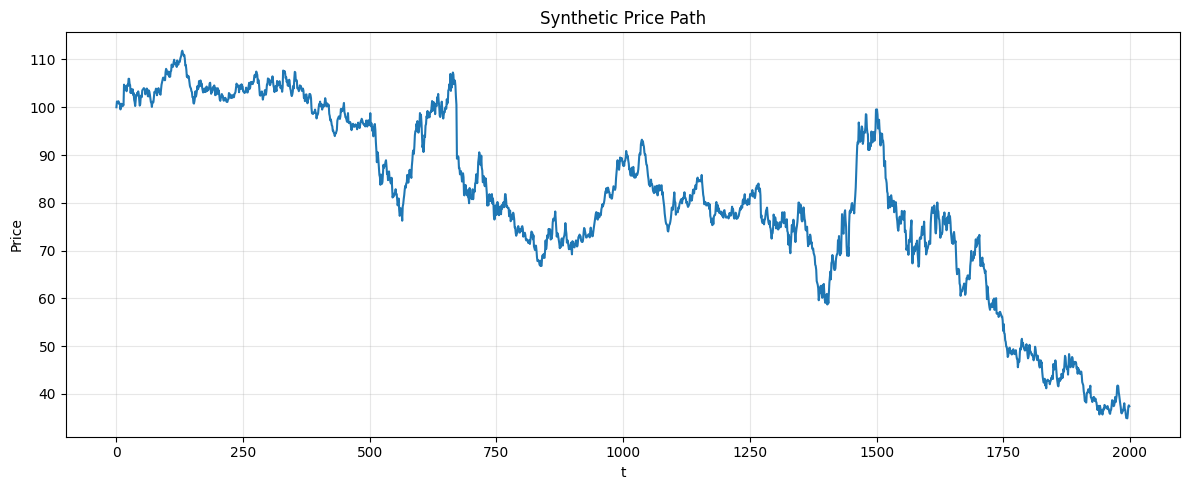

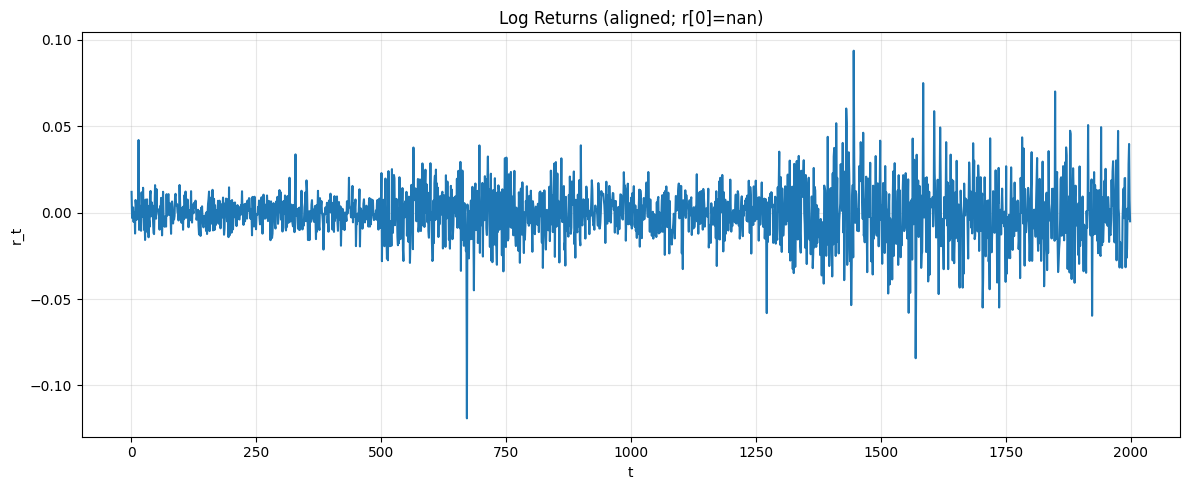

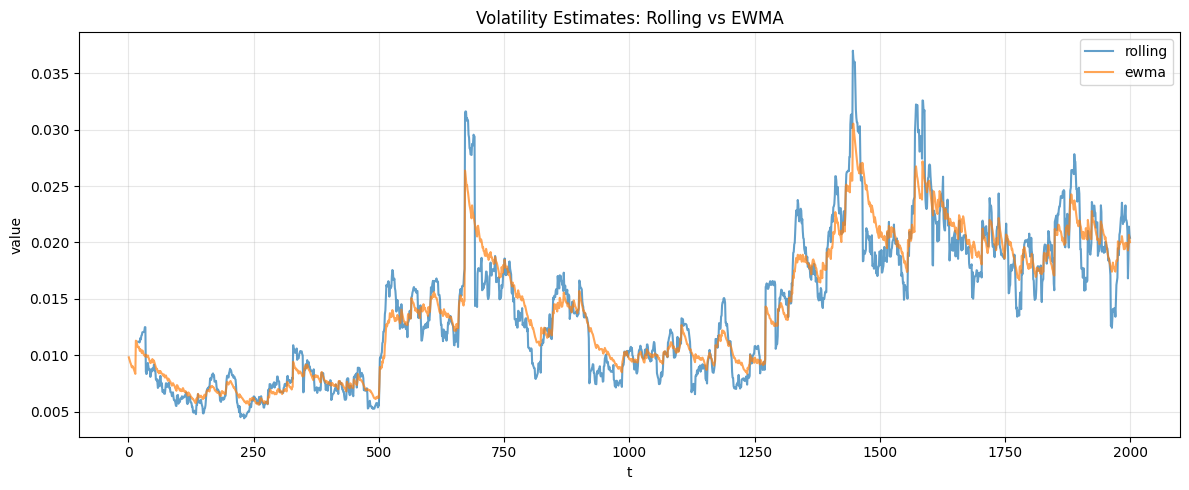

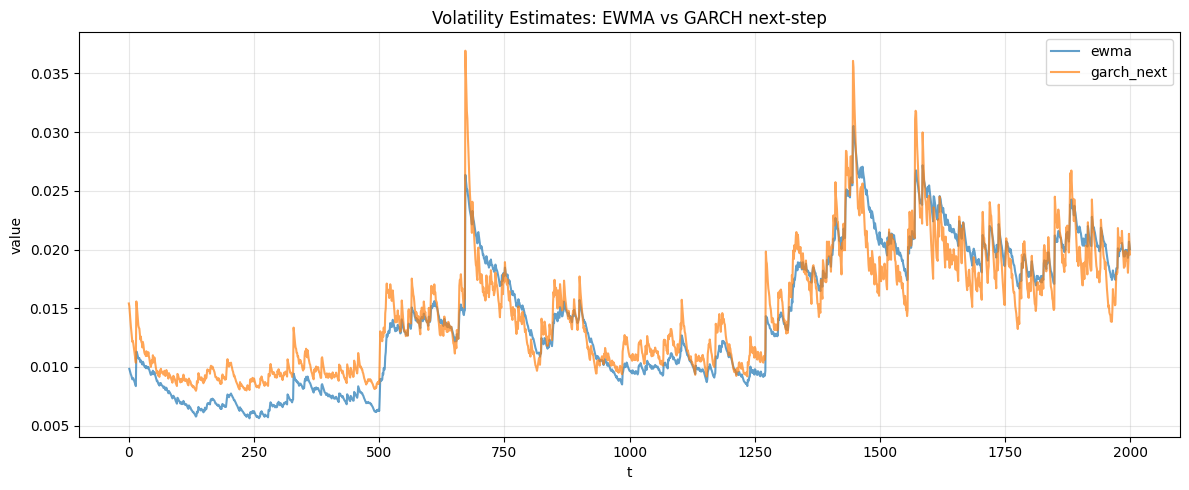

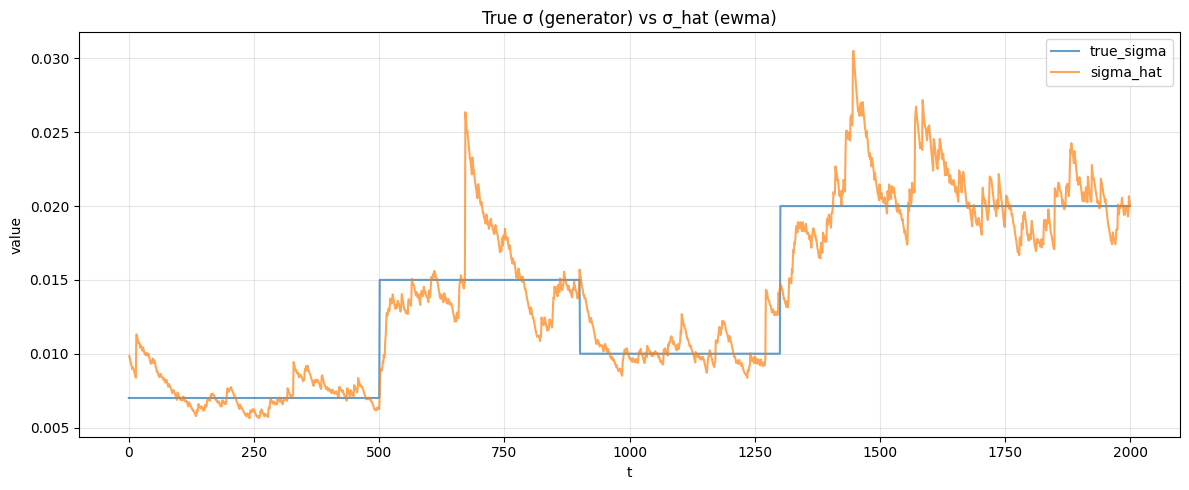

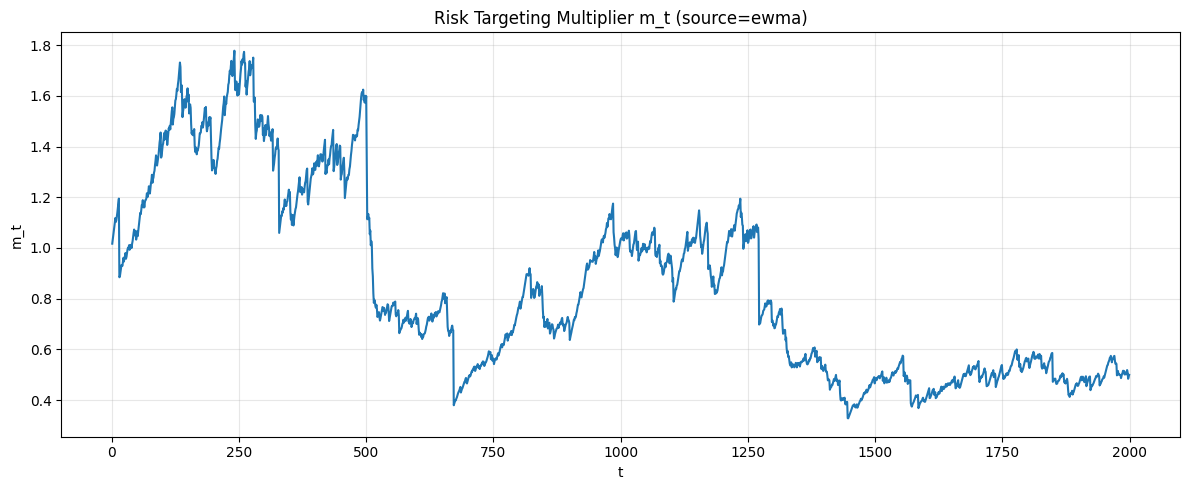

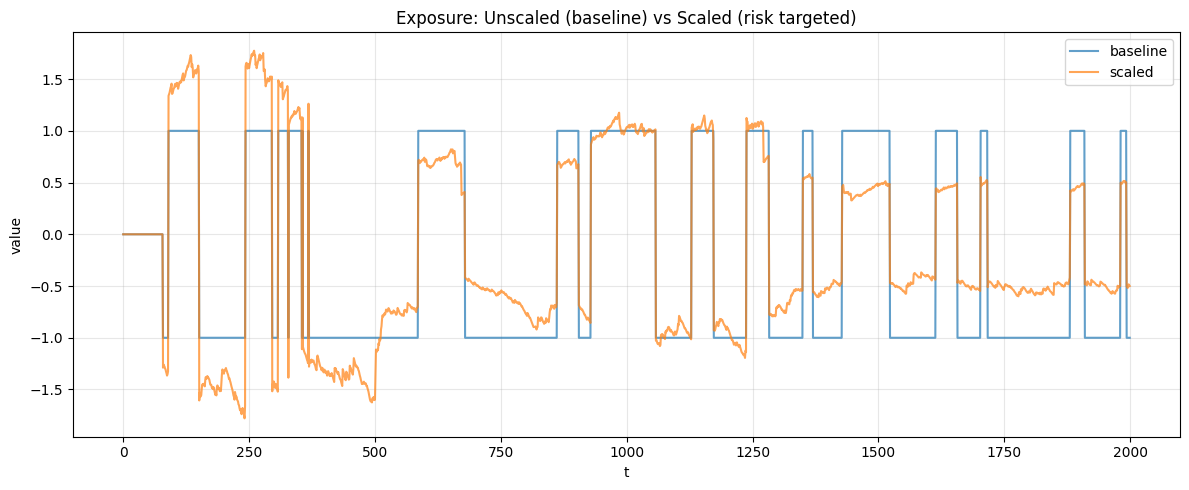

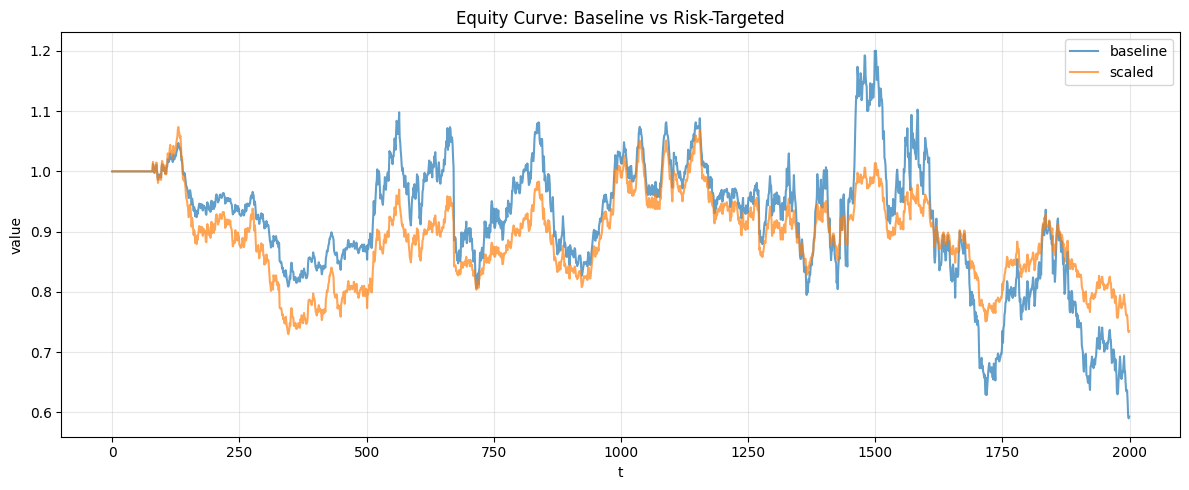

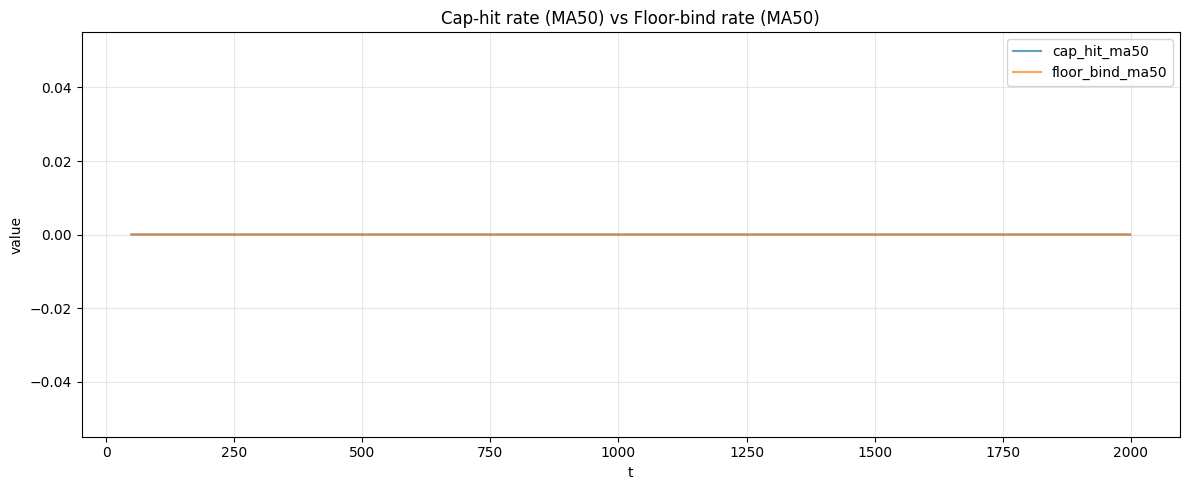

In [11]:

def plot_series(x, y, title, xlabel="t", ylabel="value", max_points=None):
    """Plot single time series."""
    if max_points is not None and y.size > max_points:
        idx = np.linspace(0, y.size - 1, max_points).astype(int)
        x = x[idx]
        y = y[idx]
    plt.figure(figsize=(12, 5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_two_series(x, y1, y2, title, labels=("a", "b"), max_points=None):
    """Plot two time series for comparison."""
    if max_points is not None and y1.size > max_points:
        idx = np.linspace(0, y1.size - 1, max_points).astype(int)
        x = x[idx]
        y1 = y1[idx]
        y2 = y2[idx]
    plt.figure(figsize=(12, 5))
    plt.plot(x, y1, label=labels[0], alpha=0.7)
    plt.plot(x, y2, label=labels[1], alpha=0.7)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

MP = int(CONFIG["reporting"]["plot_max_points"])

plot_series(t, P, "Synthetic Price Path", ylabel="Price", max_points=MP)
plot_series(t, r, "Log Returns (aligned; r[0]=nan)", ylabel="r_t", max_points=MP)

# Volatility estimates
plot_two_series(t, sigma_roll, sigma_ewma, "Volatility Estimates: Rolling vs EWMA",
               labels=("rolling", "ewma"), max_points=MP)
if sigma_garch_next is not None:
    plot_two_series(t, sigma_ewma, sigma_garch_next, "Volatility Estimates: EWMA vs GARCH next-step",
                   labels=("ewma", "garch_next"), max_points=MP)

# True sigma (generator) vs chosen estimator
plot_two_series(t, true_sigma, sigma_hat, f"True σ (generator) vs σ_hat ({sigma_source})",
               labels=("true_sigma", "sigma_hat"), max_points=MP)

# Multipliers + exposures
plot_series(t, rt["m"], f"Risk Targeting Multiplier m_t (source={sigma_source})",
           ylabel="m_t", max_points=MP)
plot_two_series(t, w_base, w_scaled, "Exposure: Unscaled (baseline) vs Scaled (risk targeted)",
               labels=("baseline", "scaled"), max_points=MP)

# Equity curves
plot_two_series(t, bt_base["eq"], bt_scaled["eq"], "Equity Curve: Baseline vs Risk-Targeted",
               labels=("baseline", "scaled"), max_points=MP)

# Cap/floor hit indicators (moving average for visibility)
cap_ma = rolling_mean_causal(rt["cap_hit"].astype(np.float64), 50)
floor_ma = rolling_mean_causal(rt["floor_bind"].astype(np.float64), 50)
plot_two_series(t, cap_ma, floor_ma, "Cap-hit rate (MA50) vs Floor-bind rate (MA50)",
               labels=("cap_hit_ma50", "floor_bind_ma50"), max_points=MP)


##10.AUDIT ARTIFACTS

###10.1.OVERVIEW



This section implements professional data governance by saving all intermediate computations and creating cryptographic fingerprints for audit trails. In production quantitative systems, being able to reproduce and verify past results is just as important as generating them in the first place.

The array saving systematically stores every major output from the pipeline. This includes the raw market data, all volatility estimates from different methods, the signal construction outputs, risk targeting decisions, and final backtest results. Each array gets saved as a binary NumPy file, preserving full numerical precision without any rounding or formatting artifacts. Years later, you can reload these exact arrays and verify that your current code produces identical results, or investigate what changed if results differ.

The organized directory structure keeps artifacts manageable. All arrays go into a dedicated subdirectory, separated from configuration files and manifests. This organization matters when you're running hundreds or thousands of backtests—clear structure prevents chaos and makes automated processing possible.

The cryptographic hashing creates unforgeable fingerprints of every saved array. Each hash is computed from the raw binary content of the file, so even a single bit difference produces a completely different hash. This serves multiple purposes: you can verify data integrity after copying files between systems, detect accidental modifications or corruption, and prove to auditors or regulators that specific results came from specific data without any tampering.

The lineage recording writes these hashes into both the run manifest and a separate hash file. The manifest becomes a complete audit trail documenting exactly what data was used, which parameters were set, which tests passed, and what outputs were generated. If someone questions your results months later, you can provide this manifest as proof of your methodology and verify that saved arrays haven't been altered.

This governance infrastructure might seem like overhead for academic exercises, but it's essential for production trading systems where reproducibility and auditability prevent costly mistakes and regulatory issues.

###10.2.CODE AND IMPLEMENTATION

In [12]:


if CONFIG["artifacts"]["save_arrays"]:
    # Create arrays subdirectory
    arrays_dir = os.path.join(ART_ROOT, "arrays")
    ensure_dir(arrays_dir)

    print("\nSaving artifacts...")

    # Core market data
    np.save(os.path.join(arrays_dir, "t.npy"), t)
    np.save(os.path.join(arrays_dir, "P.npy"), P)
    np.save(os.path.join(arrays_dir, "r.npy"), r)
    np.save(os.path.join(arrays_dir, "regimes.npy"), regimes)
    np.save(os.path.join(arrays_dir, "true_sigma.npy"), true_sigma)

    # Volatility estimator outputs
    np.save(os.path.join(arrays_dir, "sigma_roll.npy"), sigma_roll)
    np.save(os.path.join(arrays_dir, "sigma_ewma.npy"), sigma_ewma)
    if sigma_garch_next is not None:
        np.save(os.path.join(arrays_dir, "sigma_garch_next.npy"), sigma_garch_next)
        np.save(os.path.join(arrays_dir, "sigma_garch_cond.npy"), garch_out["sigma_cond"])

    # Signal construction outputs
    np.save(os.path.join(arrays_dir, "w_raw.npy"), w_raw)
    np.save(os.path.join(arrays_dir, "w_base.npy"), w_base)

    # Risk targeting outputs
    np.save(os.path.join(arrays_dir, "w_scaled.npy"), w_scaled)
    np.save(os.path.join(arrays_dir, "multiplier_m.npy"), rt["m"])
    np.save(os.path.join(arrays_dir, "w_pre.npy"), rt["w_pre"])
    np.save(os.path.join(arrays_dir, "cap_hit.npy"), rt["cap_hit"])
    np.save(os.path.join(arrays_dir, "floor_bind.npy"), rt["floor_bind"])
    np.save(os.path.join(arrays_dir, "avail.npy"), rt["avail"])

    # Backtest results
    np.save(os.path.join(arrays_dir, "R_base.npy"), bt_base["R"])
    np.save(os.path.join(arrays_dir, "eq_base.npy"), bt_base["eq"])
    np.save(os.path.join(arrays_dir, "R_scaled.npy"), bt_scaled["R"])
    np.save(os.path.join(arrays_dir, "eq_scaled.npy"), bt_scaled["eq"])

    print(f"  Saved {len(os.listdir(arrays_dir))} array files to: {arrays_dir}")

# Compute cryptographic hashes for all saved arrays (data lineage)
hashes = {}
arrays_dir = os.path.join(ART_ROOT, "arrays")
if os.path.isdir(arrays_dir):
    for filename in sorted(os.listdir(arrays_dir)):
        if filename.endswith(".npy"):
            filepath = os.path.join(arrays_dir, filename)
            with open(filepath, "rb") as f:
                hashes[filename] = sha256_bytes(f.read())

# Record hashes in manifest and separate hash file
RUN_MANIFEST["outputs"]["array_hashes"] = hashes
write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)
write_json(os.path.join(ART_ROOT, "array_hashes.json"), hashes)

print(f"\nArtifact lineage recorded:")
print(f"  Total arrays: {len(hashes)}")
if hashes:
    example_file, example_hash = next(iter(hashes.items()))
    print(f"  Example: {example_file} -> {example_hash[:16]}...")
print(f"\nAll artifacts saved to: {ART_ROOT}")


Saving artifacts...
  Saved 21 array files to: /content/ch10_artifacts/ch10_20251222T112928Z_7/arrays

Artifact lineage recorded:
  Total arrays: 21
  Example: P.npy -> a9b6bd1ac705d22d...

All artifacts saved to: /content/ch10_artifacts/ch10_20251222T112928Z_7


##11.GOVERNANCE TEST SUITE

###11.1.OVERVIEW



This final section implements mandatory quality checks that serve as hard gates—the notebook refuses to complete if any test fails. These aren't optional validations you can skip when convenient. They're non-negotiable assertions that catch the kinds of bugs that cost real money in production trading.

The monotonic time test verifies that your time index strictly increases without gaps or reversals. This might seem trivial with synthetic data, but real data often has timestamp errors from vendor feeds, timezone conversions, or data merges gone wrong. Trading on misordered data produces nonsensical results that look plausible until you discover the bug after deploying to live markets. This test catches such errors immediately.

The non-negative volatility check ensures all volatility estimates are physically meaningful. Volatility represents standard deviation of returns and must be non-negative by definition. Negative volatility indicates a severe implementation bug—perhaps incorrect variance calculations, numerical instability, or corrupted data. Finding this early prevents downstream errors that would be much harder to debug.

The leverage cap enforcement verifies that risk targeting actually respects your maximum position limits. If scaled positions exceed the cap, either the clipping logic failed or the cap parameters are inconsistent with your target volatility. This test protects against accidentally commanding overleveraged positions that could blow up your account during adverse moves.

The backtest alignment verification is perhaps most critical. It randomly samples positions and returns, explicitly checking that strategy return at time t equals position at time t minus one multiplied by market return at time t. This confirms the timing relationship is implemented correctly—a subtle bug here means your backtest doesn't reflect reality. Many trading systems fail in live markets because backtests had timing errors that made performance look better than achievable.

These tests embody defensive programming principles. Rather than hoping everything works, you explicitly verify correctness and fail loudly when assumptions are violated.

###11.2.CODE AND IMPLEMENTATION

In [13]:

# Monotonic time
mono_time = bool(np.all(np.diff(t) > 0))
assert mono_time, "Time index is not strictly increasing"
RUN_MANIFEST["tests"]["monotonic_time"] = mono_time

# Sanity: non-negative volatility where defined
def nonneg_where_finite(x: np.ndarray) -> bool:
    """Check that all finite values are non-negative."""
    m = np.isfinite(x)
    return bool(np.all(x[m] >= -1e-18))

assert nonneg_where_finite(sigma_roll), "Rolling sigma has negative values"
assert nonneg_where_finite(sigma_ewma), "EWMA sigma has negative values"
if sigma_garch_next is not None:
    assert nonneg_where_finite(sigma_garch_next), "GARCH next sigma has negative values"
RUN_MANIFEST["tests"]["nonneg_vol"] = True

# Risk targeting cap sanity
assert np.max(np.abs(w_scaled[np.isfinite(w_scaled)])) <= w_max + 1e-12, "Scaled exposure violates cap"
RUN_MANIFEST["tests"]["cap_enforced"] = True

# Alignment sanity: R[t] must be w[t-1]*r[t]
# Validate on random subset for speed (deterministic)
np.random.seed(101)
idxs = np.random.choice(np.arange(2, len(r)), size=min(50, len(r)-2), replace=False)
for tt in idxs:
    if np.isfinite(bt_scaled["R"][tt]) and np.isfinite(w_scaled[tt-1]) and np.isfinite(r[tt]):
        if abs(bt_scaled["R"][tt] - w_scaled[tt-1]*r[tt]) > 1e-12:
            raise AssertionError(f"Backtest alignment failed at t={tt}: R[t] != w[t-1]*r[t]")
RUN_MANIFEST["tests"]["backtest_alignment"] = True

write_json(os.path.join(ART_ROOT, "run_manifest.json"), RUN_MANIFEST)
print("\nAll governance tests PASSED.")
print(f"Final manifest: {os.path.join(ART_ROOT, 'run_manifest.json')}")





All governance tests PASSED.
Final manifest: /content/ch10_artifacts/ch10_20251222T112928Z_7/run_manifest.json
